# 1. Import thư viện

In [2]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib as plt
from pylab import *
import seaborn as sns

# 2. DĐọc file RFM của Quân

In [3]:
#data = data_backup.copy()
data = pd.read_csv(r"D:/Folder_Thanhvv/CeDX/code/RFM_segmentation_2.csv", encoding='utf-8')
data = data.dropna()
segment = pd.DataFrame(data['Segment'])
#data = data[data['view_product_detail'] < 50]
#data = data[data['BATTERY'] < 40]
#data = data.drop('UID', axis=1)

# 3. Fit và transform tập dữ liệu

In [4]:
data = data.drop('Segment', axis=1)
scaler = StandardScaler()
sc = scaler.fit_transform(data)
z = pd.DataFrame(sc, index=data.index, columns=data.columns)

# 4. DĐổi Segment RFM thành số nguyên

<AxesSubplot:ylabel='Point'>

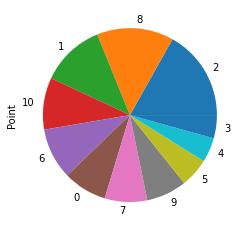

In [5]:
z['Point'] = segment['Segment'].replace(['Lost', "Hibernating", "At Risk", "About To Sleep", 'Cannot Lose Them', 'Need Attention', 'Promising',
        'New Customer', 'Potential Loyalist', 'Loyal Customer', 'Champion'], range(0,11))
v = z['Point']
v.value_counts().plot(kind="pie")

In [5]:
!pip install imbalanced-learn==0.8

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\BV980921\Anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 173, in _main
    status = self.run(options, args)
  File "C:\Users\BV980921\Anaconda3\lib\site-packages\pip\_internal\cli\req_command.py", line 203, in wrapper
    return func(self, options, args)
  File "C:\Users\BV980921\Anaconda3\lib\site-packages\pip\_internal\commands\install.py", line 315, in run
    requirement_set = resolver.resolve(
  File "C:\Users\BV980921\Anaconda3\lib\site-packages\pip\_internal\resolution\resolvelib\resolver.py", line 94, in resolve
    result = self._result = resolver.resolve(
  File "C:\Users\BV980921\Anaconda3\lib\site-packages\pip\_vendor\resolvelib\resolvers.py", line 472, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "C:\Users\BV980921\Anaconda3\lib\site-packages\pip\_vendor\resolvelib\resolvers.py", line 341, in resolve
    self._add_to_criteria(self.state.criter

In [6]:
!python -m pip install scikit-learn==0.18

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\BV980921\Anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 173, in _main
    status = self.run(options, args)
  File "C:\Users\BV980921\Anaconda3\lib\site-packages\pip\_internal\cli\req_command.py", line 203, in wrapper
    return func(self, options, args)
  File "C:\Users\BV980921\Anaconda3\lib\site-packages\pip\_internal\commands\install.py", line 315, in run
    requirement_set = resolver.resolve(
  File "C:\Users\BV980921\Anaconda3\lib\site-packages\pip\_internal\resolution\resolvelib\resolver.py", line 94, in resolve
    result = self._result = resolver.resolve(
  File "C:\Users\BV980921\Anaconda3\lib\site-packages\pip\_vendor\resolvelib\resolvers.py", line 472, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "C:\Users\BV980921\Anaconda3\lib\site-packages\pip\_vendor\resolvelib\resolvers.py", line 341, in resolve
    self._add_to_criteria(self.state.criter

# 5. Xử lý dl mất cân băng bằng over sampling data 

In [6]:
#import imblearn
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=42, k_neighbors=5, n_jobs = -1, sampling_strategy = 'not majority')
z, v = oversample.fit_resample(z, v)

C:\Users\BV980921\Anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


# 6. Loại bỏ hệ số high covariance của ma trận hiệp phương sai

In [7]:
# Tính ma trận hiệp phương sai giữa các cột
cov_matrix = z.corr().abs()

# Lấy danh sách các cột có giá trị tuyệt đối của hiệp phương sai lớn hơn ngưỡng cho trước 
high_cov_cols = cov_matrix[cov_matrix >= 0.8].stack().reset_index().query('level_0 != level_1')['level_1'].unique()

# Xóa các cột có tên trong danh sách high_cov_cols và các cột không sử dụng
z.drop(columns=high_cov_cols, inplace=True)
z.drop(columns=['rMonetary', 'Unnamed: 0', 'UID', 'Point'], inplace=True)

# 7. Vẽ ma trận hiệp phương sai

<AxesSubplot:>

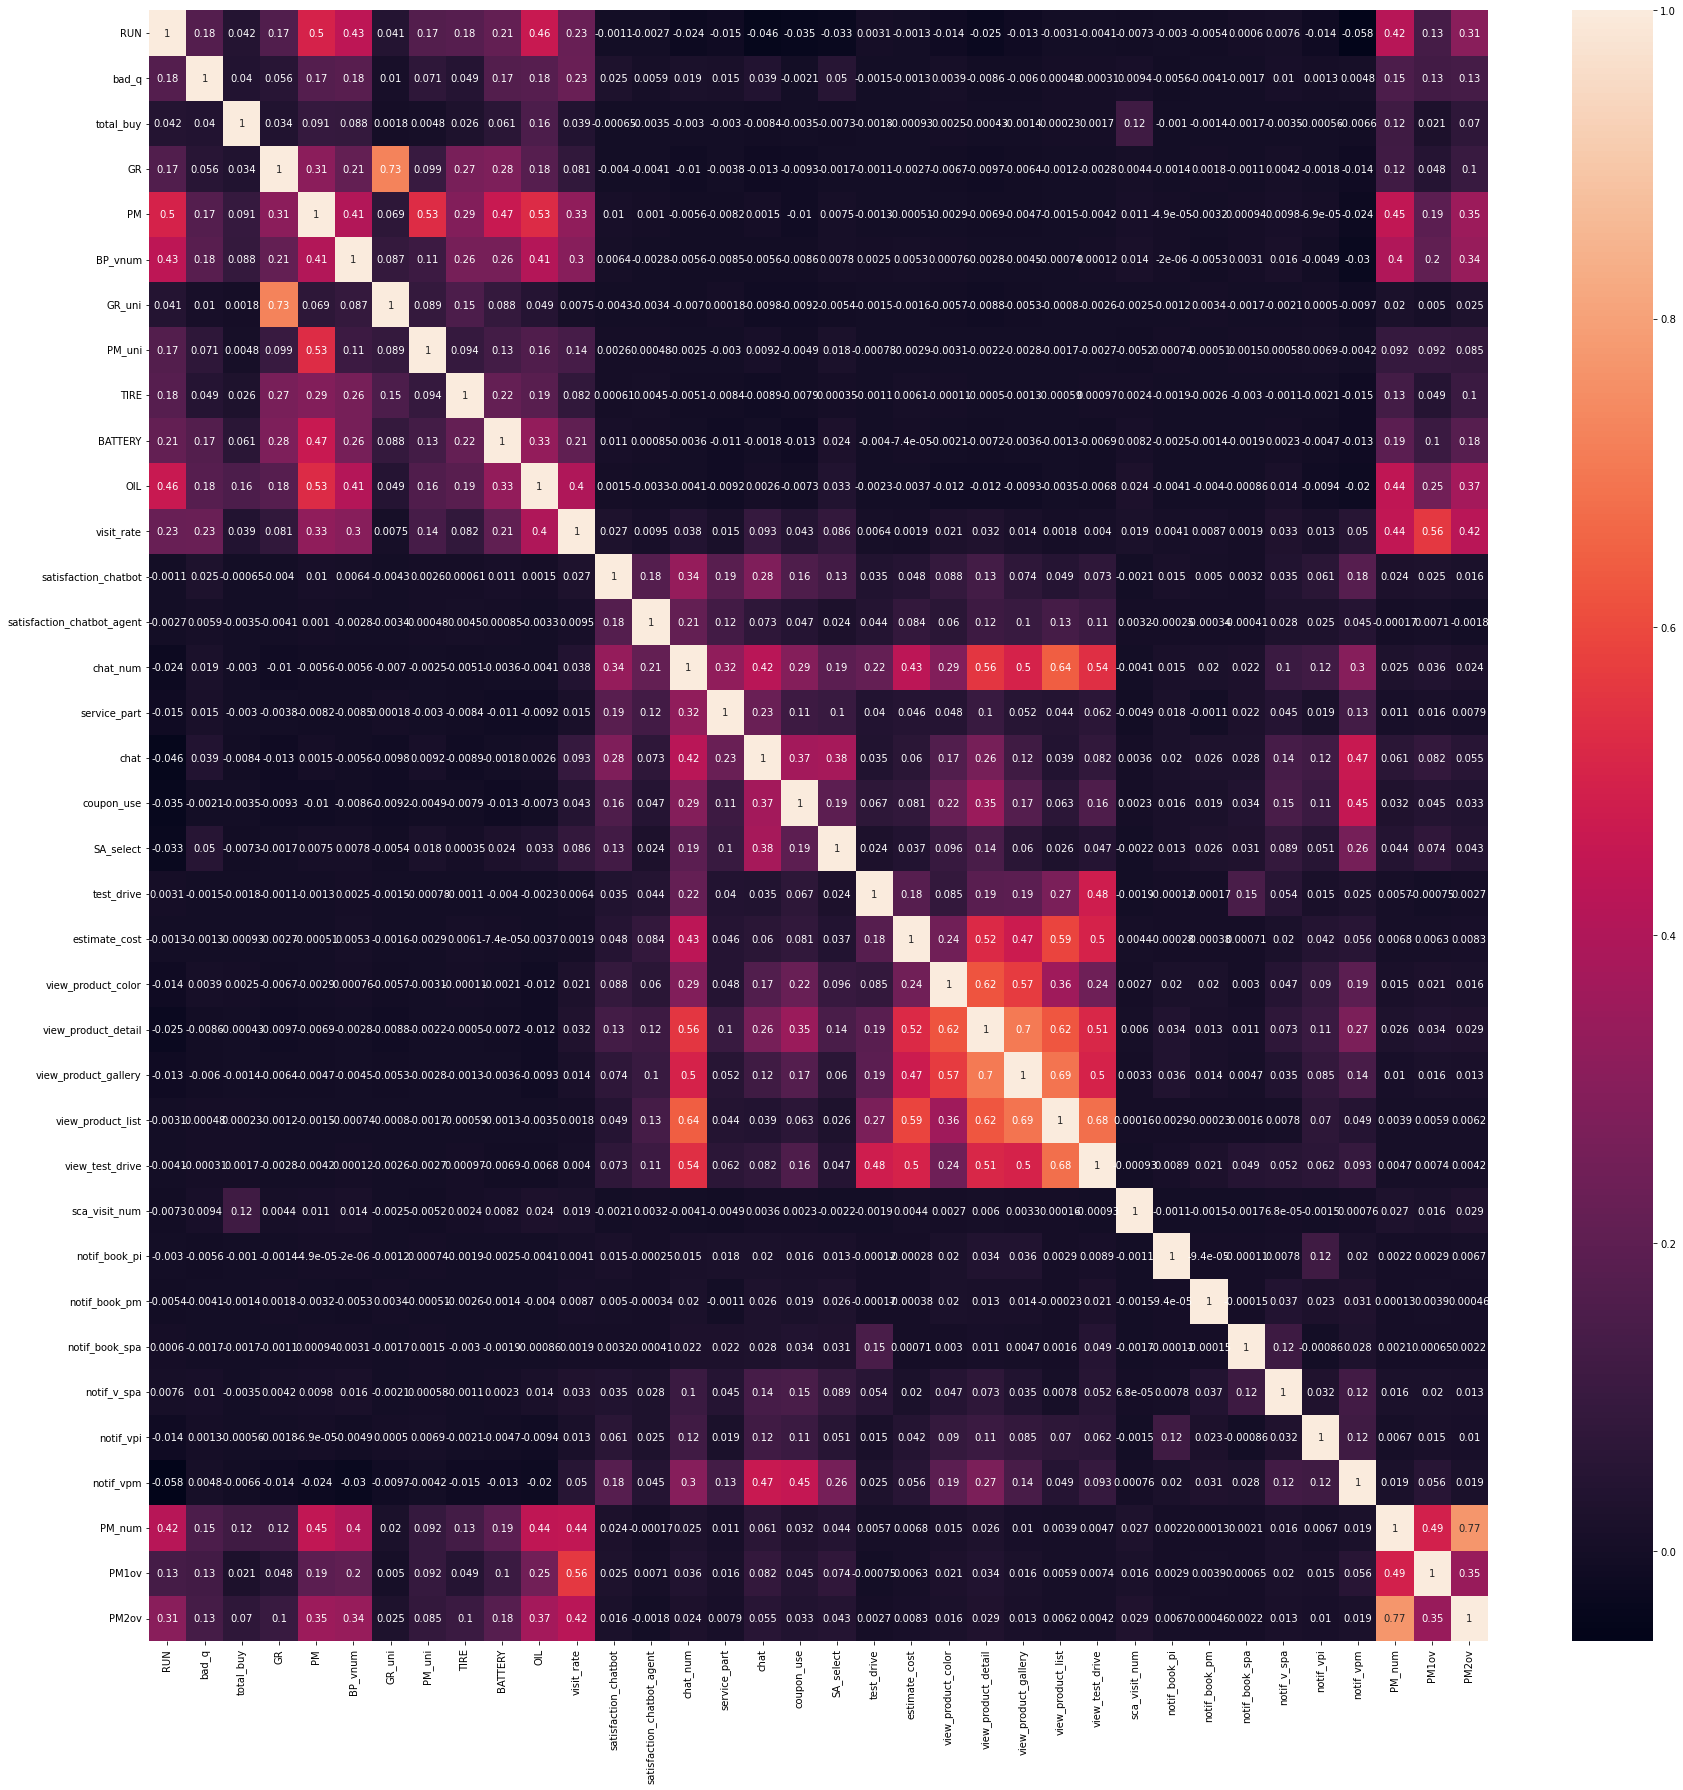

In [12]:
corr_matrix = z.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True)

In [8]:
len(z.columns)

36

# 8. Split data

In [9]:
from sklearn.model_selection import train_test_split
Z_train, Z_test, v_train, v_test = train_test_split(z, v, test_size=0.2, random_state = 42, shuffle=True, stratify = v)

# 9. Tìm model có accuracy và f1 score cao nhất

In [19]:
from sklearn.neural_network import MLPClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
classifiers = [KNeighborsClassifier(1),
                DecisionTreeClassifier(),
                RandomForestClassifier(),
                MLPClassifier(hidden_layer_sizes=(100, 100, 100),
                             max_iter=10000, activation='relu'),              
                MLPClassifier(hidden_layer_sizes=(100, 100, 100),
                             max_iter=10000, activation='tanh'),
                GaussianNB(),
                XGBClassifier(),
                LogisticRegression()]

clf_names =["Nearest Neighbors (k=1)",
            "Decision Tree ()", 
             "Random Forest ()",
             "MLP (RelU)", "MLP (tanh)",
             "Gaussian Naive Bayes",
             "XGBoost",
            "Logistic Regression"]
scores_micro = dict()
scores_macro = dict()
scores_mcc = dict()
for name, clf in zip(clf_names, classifiers):
#   print("fitting classifier", name)
    clf.fit(Z_train,v_train)
#   print("predicting labels for classifier", name)
    v_pred = clf.predict(Z_test)
    scores_micro[name] = precision_recall_fscore_support(
                    v_test,v_pred, average="micro")
    scores_macro[name] = precision_recall_fscore_support(
                    v_test, v_pred, average="macro")

scores_micro_df = pd.DataFrame(scores_micro, index=[
                               'precision (micro)', 'recall (micro)', 'fscore (micro)', 'support'])
scores_micro_df = scores_micro_df[0:3]  # drop support
scores_macro_df = pd.DataFrame(scores_macro, index=[
                               'precision (macro)', 'recall (macro)', 'fscore (macro)', 'support'])
scores_macro_df = scores_macro_df[0:3]
scores_df = scores_macro_df.append(scores_micro_df)
scores_df.head()

C:\Users\BV980921\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Nearest Neighbors (k=1),Decision Tree (),Random Forest (),MLP (RelU),MLP (tanh),Gaussian Naive Bayes,XGBoost,Logistic Regression
precision (macro),0.590853,0.438810,0.597230,0.487383,0.472313,0.237291,0.505290,0.380578
recall (macro),0.601842,0.439597,0.602105,0.493692,0.476632,0.212642,0.505083,0.389065
fscore (macro),0.594737,0.439179,0.597837,0.483552,0.473382,0.122811,0.502905,0.380391
precision (micro),0.601830,0.439592,0.602098,0.493683,0.476625,0.212608,0.505077,0.389055
recall (micro),0.601830,0.439592,0.602098,0.493683,0.476625,0.212608,0.505077,0.389055


# 10. Tìm tham số tối ưu cho model đã chọn

In [20]:
import optuna
import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection

def objective(trial):
    iris = sklearn.datasets.load_iris()
    
    n_estimators = trial.suggest_int('n_estimators', 1, 200)
    max_depth = int(trial.suggest_float('max_depth', 1, 100, log=True))

    
    clf = sklearn.ensemble.RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth)
    
    return sklearn.model_selection.cross_val_score(
        clf, iris.data, iris.target, n_jobs=-1, cv=3).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-06-01 09:10:29,017] A new study created in memory with name: no-name-c022f5dc-50c4-4e50-84d4-e25b29f61c9f
[I 2023-06-01 09:10:32,291] Trial 0 finished with value: 0.9666666666666667 and parameters: {'n_estimators': 23, 'max_depth': 19.65004619526514}. Best is trial 0 with value: 0.9666666666666667.
[I 2023-06-01 09:10:33,525] Trial 1 finished with value: 0.9533333333333333 and parameters: {'n_estimators': 165, 'max_depth': 27.371896884646826}. Best is trial 0 with value: 0.9666666666666667.
[I 2023-06-01 09:10:34,582] Trial 2 finished with value: 0.9666666666666667 and parameters: {'n_estimators': 66, 'max_depth': 4.426189473574882}. Best is trial 0 with value: 0.9666666666666667.
[I 2023-06-01 09:10:34,666] Trial 3 finished with value: 0.9533333333333333 and parameters: {'n_estimators': 55, 'max_depth': 5.369661448569615}. Best is trial 0 with value: 0.9666666666666667.
[I 2023-06-01 09:10:34,750] Trial 4 finished with value: 0.9666666666666667 and parameters: {'n_estimators':

[I 2023-06-01 09:10:39,501] Trial 40 finished with value: 0.9666666666666667 and parameters: {'n_estimators': 121, 'max_depth': 18.451680015770073}. Best is trial 0 with value: 0.9666666666666667.
[I 2023-06-01 09:10:39,563] Trial 41 finished with value: 0.96 and parameters: {'n_estimators': 27, 'max_depth': 12.356696958432801}. Best is trial 0 with value: 0.9666666666666667.
[I 2023-06-01 09:10:39,648] Trial 42 finished with value: 0.9533333333333333 and parameters: {'n_estimators': 39, 'max_depth': 10.697905373502364}. Best is trial 0 with value: 0.9666666666666667.
[I 2023-06-01 09:10:39,679] Trial 43 finished with value: 0.9666666666666667 and parameters: {'n_estimators': 9, 'max_depth': 14.084155518914452}. Best is trial 0 with value: 0.9666666666666667.
[I 2023-06-01 09:10:39,764] Trial 44 finished with value: 0.96 and parameters: {'n_estimators': 51, 'max_depth': 7.049810638702476}. Best is trial 0 with value: 0.9666666666666667.
[I 2023-06-01 09:10:40,018] Trial 45 finished wit

[I 2023-06-01 09:10:44,463] Trial 81 finished with value: 0.96 and parameters: {'n_estimators': 93, 'max_depth': 3.9492304811926124}. Best is trial 0 with value: 0.9666666666666667.
[I 2023-06-01 09:10:44,625] Trial 82 finished with value: 0.9666666666666667 and parameters: {'n_estimators': 89, 'max_depth': 9.22124967465228}. Best is trial 0 with value: 0.9666666666666667.
[I 2023-06-01 09:10:44,810] Trial 83 finished with value: 0.9666666666666667 and parameters: {'n_estimators': 111, 'max_depth': 5.992308363822288}. Best is trial 0 with value: 0.9666666666666667.
[I 2023-06-01 09:10:44,995] Trial 84 finished with value: 0.96 and parameters: {'n_estimators': 129, 'max_depth': 3.347417602146417}. Best is trial 0 with value: 0.9666666666666667.
[I 2023-06-01 09:10:45,137] Trial 85 finished with value: 0.96 and parameters: {'n_estimators': 74, 'max_depth': 5.767587685838501}. Best is trial 0 with value: 0.9666666666666667.
[I 2023-06-01 09:10:45,496] Trial 86 finished with value: 0.96666

Accuracy: 0.9666666666666667
Best hyperparameters: {'n_estimators': 23, 'max_depth': 19.65004619526514}


# 11. Chọn Random Forest vs tham số đã chọn cho model training

In [10]:
# random forest
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

model_RF = RandomForestClassifier(n_estimators=23, max_depth=19)
model_RF.fit(Z_train, v_train)
v_pred_RF = model_RF.predict(Z_test)

# 12. Tính toán lại các Accuracy, F1 score, vẽ confusion matrix

In [11]:
print('Accuracy of model ', accuracy_score(v_test, v_pred_RF))

from sklearn.metrics import f1_score
f1 = f1_score(v_test, v_pred_RF, average = 'weighted')
print("F1 Score:", f1)

Accuracy of model  0.5373437084330939
F1 Score: 0.5316417843246111


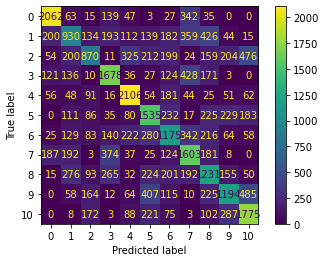

<Figure size 2160x2160 with 0 Axes>

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(v_test, v_pred_RF, labels=model_RF.classes_)
disp = ConfusionMatrixDisplay(cm,  display_labels=model_RF.classes_)
disp.plot()
plt.figure(figsize=(30,30))
plt.show()

# 13. Tính toán importance_feature

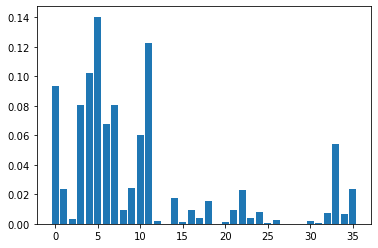

The strongest KPI is BP_vnum 0.14045739275080663
The weakness KPI is notif_book_pi 9.844354545066467e-06


In [13]:
import matplotlib.pyplot as plt

# importance func
importance_RF = model_RF.feature_importances_

#plot feature importance
plt.bar([x for x in range(len(importance_RF))], importance_RF)
plt.show()

max_value = np.argmax(importance_RF)
i = z.columns
print('The strongest KPI is ' + i[max_value], max(importance_RF))
min_value = np.argmin(importance_RF)
print('The weakness KPI is ' + i[min_value],  min(importance_RF))

# 14. Tính toán CeDX score với hàm sigmoid

In [14]:
df = pd.DataFrame(columns=[col_X for col_X in range(z.shape[1])])
for col,index in zip(range(z.shape[1]), range(len(importance_RF))):
    mul = z.iloc[:,col]*importance_RF[index]
    df[col] = mul

In [15]:
from scipy.special import expit
x = df.sum(axis=1)
df['CeDX_score'] = expit(x)

# 15. Tạo bảng và vẽ đồ thị CeDX score với các thông số liên quan

In [16]:
RFM = pd.read_csv('RFM_segmentation_2.csv')

In [17]:
RFM_CeDX = pd.concat([df['CeDX_score'], RFM], axis=1)

In [220]:
pd.DataFrame(RFM_CeDX).to_csv('RFM_CeDX.csv', index=False)

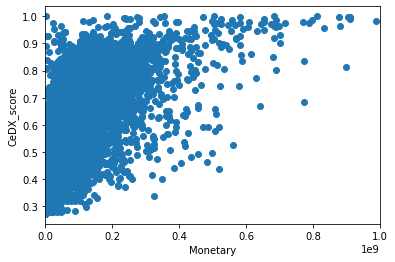

In [18]:
x = RFM_CeDX['Monetary']
y = RFM_CeDX['CeDX_score']
plt.xlim(0, 1000000000)
plt.scatter(x, y)
plt.xlabel('Monetary')
plt.ylabel('CeDX_score')
plt.show()

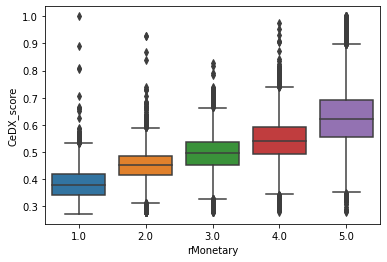

In [22]:
graph_monetary = sns.boxplot(data=RFM_CeDX, x='rMonetary', y="CeDX_score")

[Text(0, 0, 'Lost'),
 Text(1, 0, 'Hibernating'),
 Text(2, 0, 'At Risk'),
 Text(3, 0, 'About To Sleep'),
 Text(4, 0, 'Cannot Lose Them'),
 Text(5, 0, 'Need Attention'),
 Text(6, 0, 'Promising'),
 Text(7, 0, 'New Customer'),
 Text(8, 0, 'Potential Loyalist'),
 Text(9, 0, 'Loyal Customer'),
 Text(10, 0, 'Champion')]

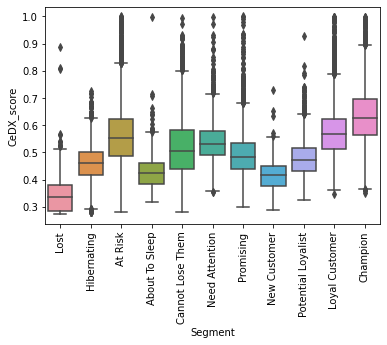

In [20]:
RFM_CeDX = RFM_CeDX.sort_values("CeDX_score")
order=["Lost", "Hibernating", "At Risk", "About To Sleep", 'Cannot Lose Them', 'Need Attention','Promising', 'New Customer', 'Potential Loyalist', 'Loyal Customer', 'Champion']
graph = sns.boxplot(data=RFM_CeDX, x="Segment", y="CeDX_score", order=order)
graph.set_xticklabels(graph.get_xticklabels(), rotation=90)
#graph.set_xticklabels(["Lost", "Hibernating", "At Risk", "About to Sleep", 'Cannot Lose Them', 'Need Attention','Promising', 'New Customer', 'Potential Loyalist', 'Loyal Customer', 'Champion'])

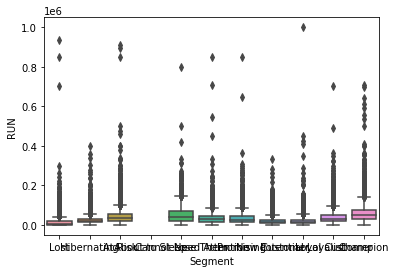

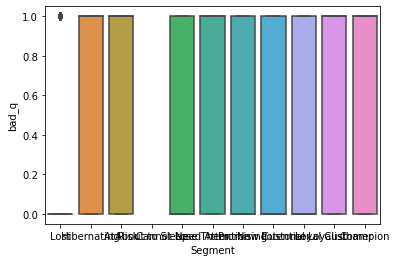

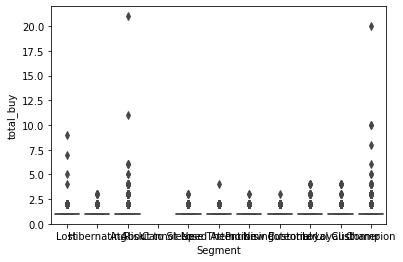

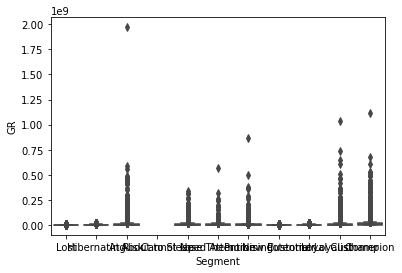

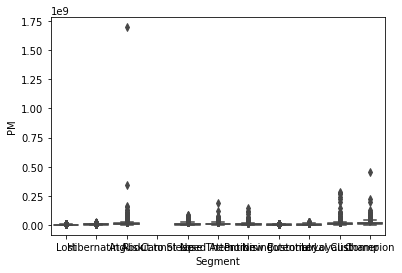

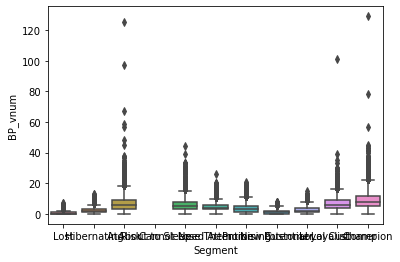

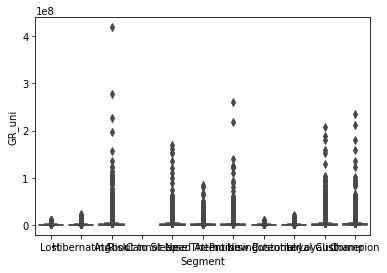

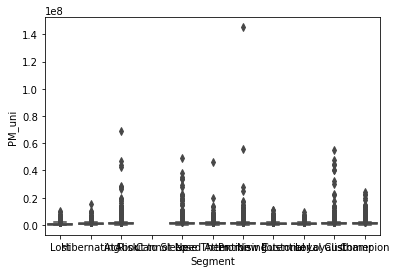

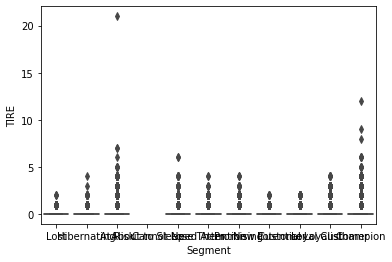

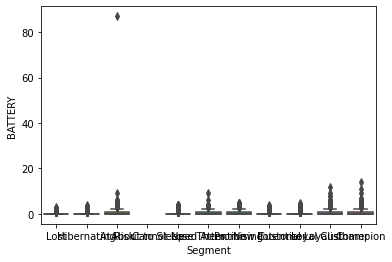

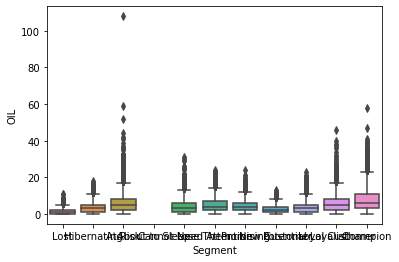

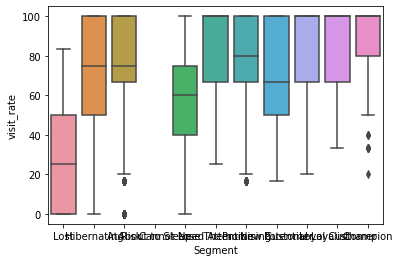

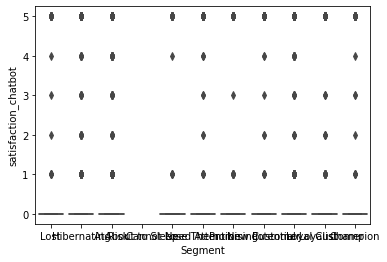

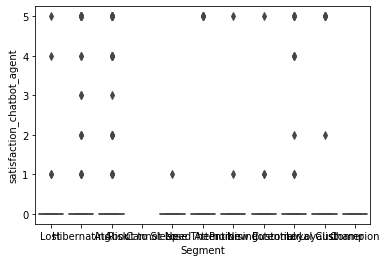

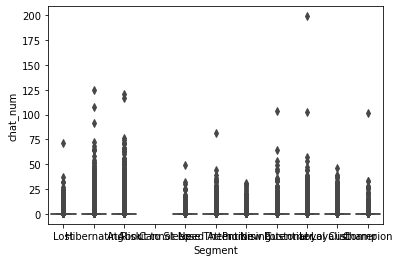

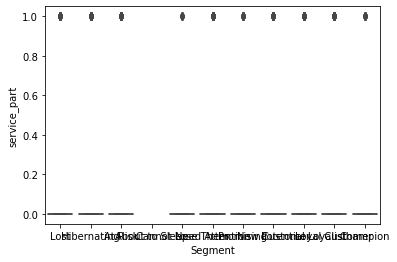

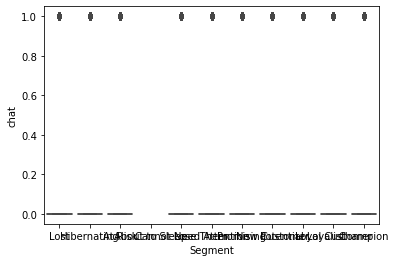

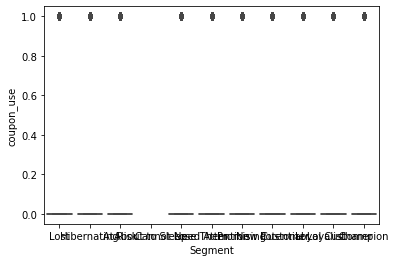

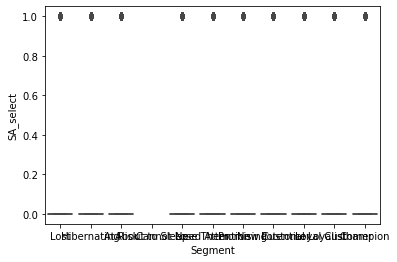

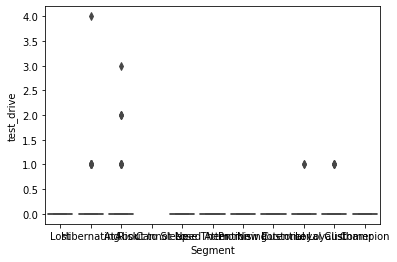

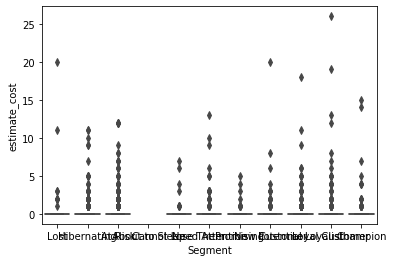

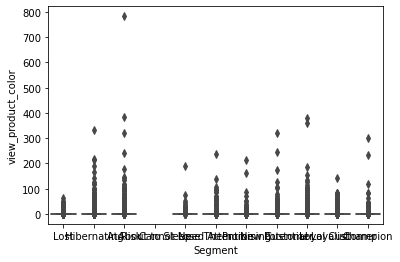

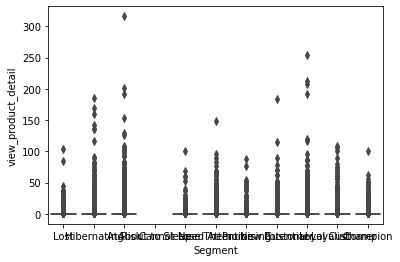

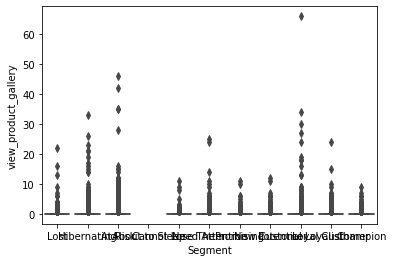

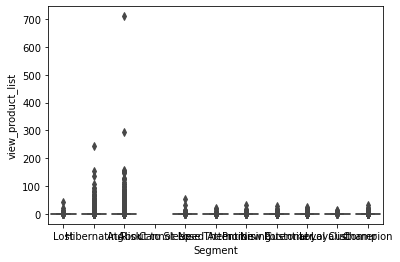

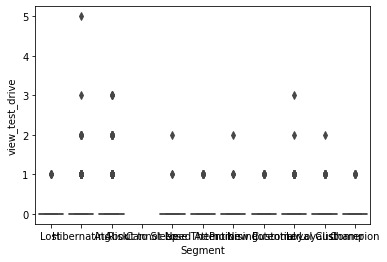

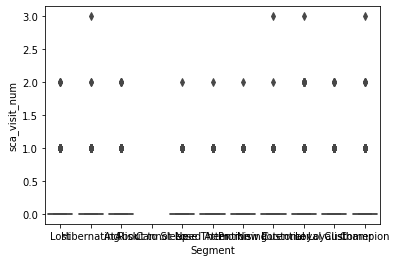

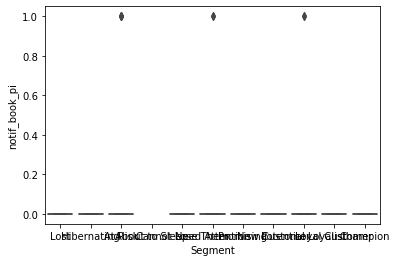

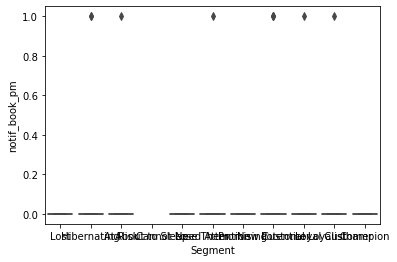

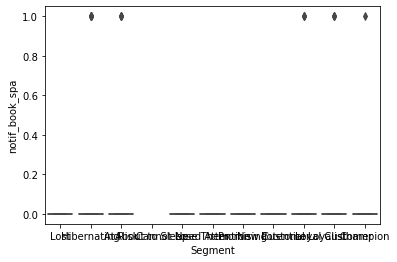

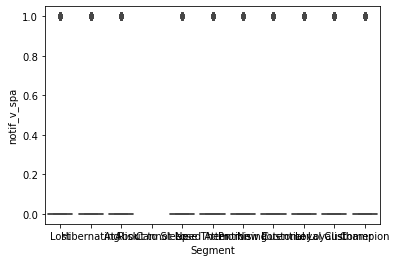

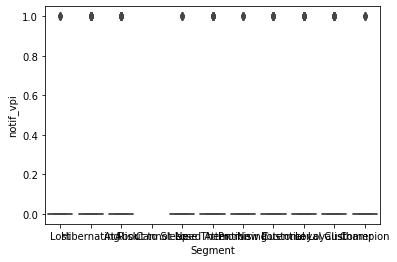

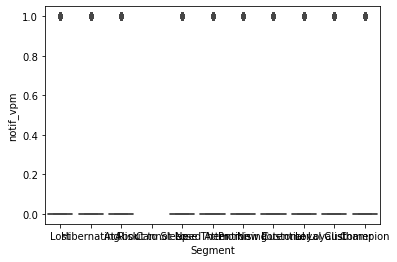

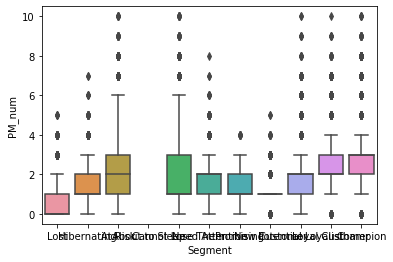

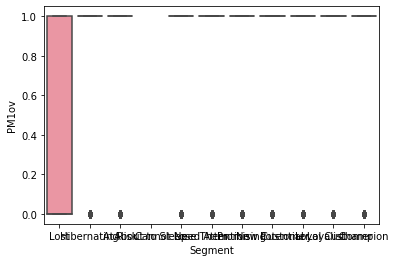

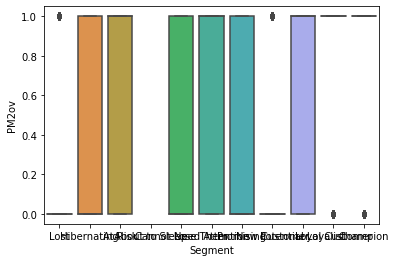

In [21]:
order=["Lost", "Hibernating", "At Risk", "About to Sleep", 'Cannot Lose Them', 'Need Attention','Promising', 'New Customer', 'Potential Loyalist', 'Loyal Customer', 'Champion']
for count in range(0, len(z.columns)):   
    graphs = sns.boxplot(data=RFM_CeDX, x="Segment", y=z.columns[count], order = order)    
    graph.set_xticklabels(graph.get_xticklabels(), rotation=90)
 #   graph.set_xticklabels(["Lost", "Hibernating", "At Risk", "Abount to Sleep", 'Cannot Lose Them', 'Need Attention','Promising', 'New Customer', 'Potential Loyalist', 'Loyal Customer', 'Champion'])
    plt.show()

In [74]:
sale_uni = pd.read_csv(r'D:/Folder_Thanhvv/CeDX/code/data/sale_uni_min.csv')

In [75]:
sale_uni['UID']

0             1_0.0
1             1_1.0
2             1_2.0
3             1_3.0
4             1_4.0
            ...    
133509    5_53064.0
133510    5_53065.0
133511    5_53066.0
133512    5_53067.0
133513    5_53068.0
Name: UID, Length: 133514, dtype: object

In [76]:
sale_uni['UID'] = sale_uni['UID'].apply(lambda x: x.replace('.0', ''))
sale_uni['UID']

0             1_0
1             1_1
2             1_2
3             1_3
4             1_4
           ...   
133509    5_53064
133510    5_53065
133511    5_53066
133512    5_53067
133513    5_53068
Name: UID, Length: 133514, dtype: object

In [77]:
df_join_jobs = pd.merge(RFM, sale_uni , on='UID', how='left')
df_join_jobs.dropna(subset=['OCCUPATION'], inplace=True)

In [223]:
pd.DataFrame(df_join_jobs).to_csv('RFM_sale.csv', index=False)

<AxesSubplot:ylabel='OCCUPATION'>

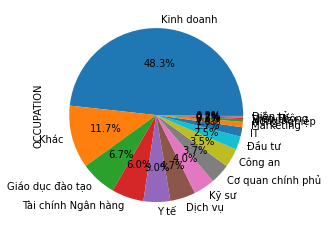

In [94]:
df_join_jobs['OCCUPATION'].value_counts().plot(kind='pie', autopct = '%1.1f%%')

Text(0.5, 1.0, 'Bar chart nhóm Kinh doanh')

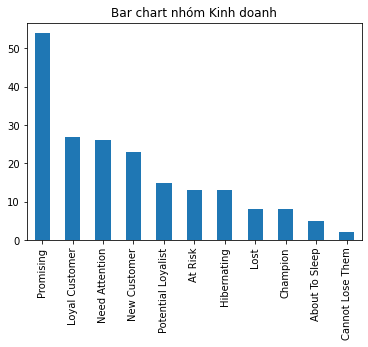

In [120]:
df_test = df_join_jobs[df_join_jobs['OCCUPATION'] == 'Kinh doanh']
df_test['Segment'].value_counts().plot(kind='bar')
plt.title('Bar chart nhóm Kinh doanh')

Text(0.5, 1.0, 'Pie chart nghề nghiệp nhóm At Risk')

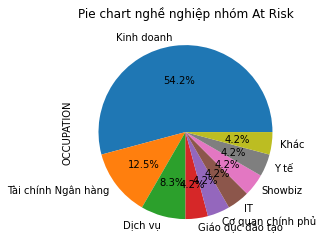

In [100]:
df_test2 = df_join_jobs[df_join_jobs['Segment'] == 'At Risk']
df_test2['OCCUPATION'].value_counts().plot(kind='pie', autopct = '%1.1f%%')
plt.title("Pie chart nghề nghiệp nhóm At Risk")

In [106]:
df_join_region.dropna(subset=['REGION'], inplace=True)

<AxesSubplot:ylabel='REGION'>

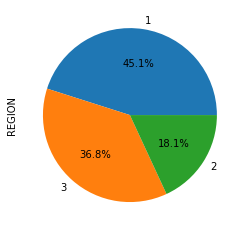

In [107]:
df_join_region['REGION'].value_counts().plot(kind='pie', autopct = '%1.1f%%')

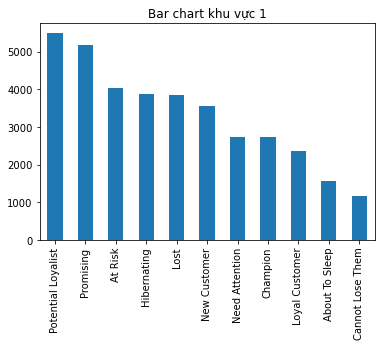

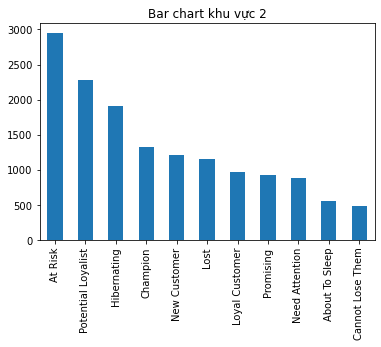

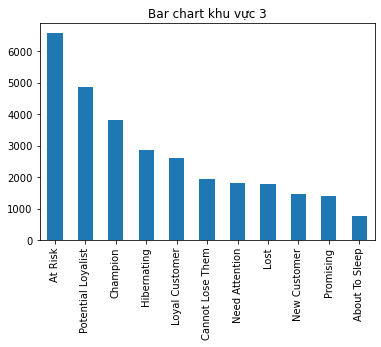

In [178]:
for reg in range(1,4):
    df_test3 = df_join_region[df_join_region['REGION'] == reg]
    df_test3['Segment'].value_counts().plot(kind='bar')
    plt.title(f'Bar chart khu vực {i}')
    i+=1
    plt.show()
   

In [132]:
df_age = pd.read_csv(r'D:\Folder_Thanhvv\CeDX\code\dataset_all RFM gender_age.csv')

In [137]:
df_age.dropna(subset=['age'], inplace=True)

[Text(0, 0, 'Lost'),
 Text(1, 0, 'Hibernating'),
 Text(2, 0, 'At Risk'),
 Text(3, 0, 'Abount to Sleep'),
 Text(4, 0, 'Cannot Lose Them'),
 Text(5, 0, 'Need Attention'),
 Text(6, 0, 'Promising'),
 Text(7, 0, 'New Customer'),
 Text(8, 0, 'Potential Loyalist'),
 Text(9, 0, 'Loyal Customer'),
 Text(10, 0, 'Champion')]

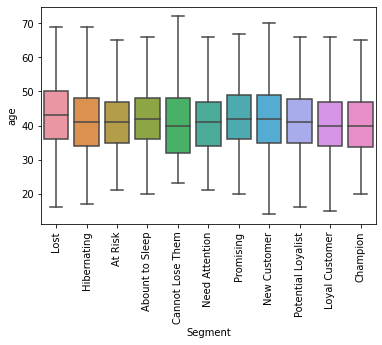

In [205]:
graph_gender = sns.boxplot(data=df_gender, x="Segment", y="age", showfliers=False, order=order)
graph_gender.set_xticklabels(graph.get_xticklabels(), rotation=90)
graph_gender.set_xticklabels(["Lost", "Hibernating", "At Risk", "Abount to Sleep", 'Cannot Lose Them', 'Need Attention','Promising', 'New Customer', 'Potential Loyalist', 'Loyal Customer', 'Champion'])

In [141]:
df_gender = pd.read_csv(r'D:\Folder_Thanhvv\CeDX\code\dataset_all RFM gender_age.csv')

In [143]:
df_gender.dropna(subset=['GENDER'], inplace=True)

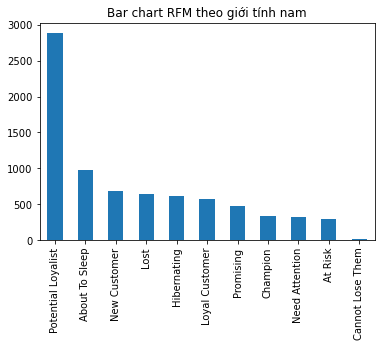

In [153]:
    df_test3 = df_gender[df_gender['GENDER'] == 'Male']
    df_test3['Segment'].value_counts().plot(kind='bar')
    plt.title('Bar chart RFM theo giới tính nam')
    plt.show()

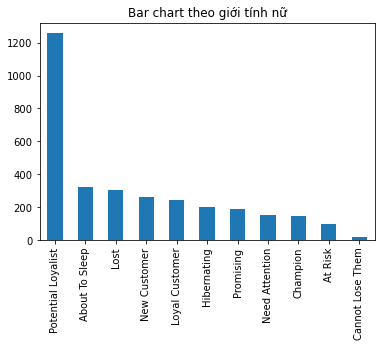

In [151]:
    df_test3 = df_gender[df_gender['GENDER'] == 'Female']
    df_test3['Segment'].value_counts().plot(kind='bar')
    plt.title('Bar chart theo giới tính nữ')
    plt.show()

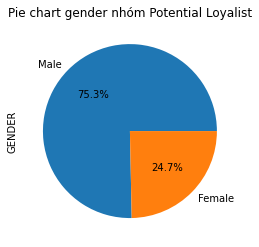

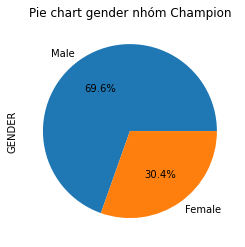

In [218]:
#fig, (df_test4, df_test5) = plt.subplots(1, 2)

df_test4 = df_gender[df_gender['Segment'] == 'At Risk']
df_test4['GENDER'].value_counts().plot(kind='pie', autopct = '%1.1f%%')
plt.title("Pie chart gender nhóm Potential Loyalist")
plt.show()

df_test5 = df_gender[df_gender['Segment'] == 'Champion']
df_test5['GENDER'].value_counts().plot(kind='pie', autopct = '%1.1f%%')
plt.title("Pie chart gender nhóm Champion")

plt.show()